# 📘 Donut 模型架构详解与自定义训练指南（适合多语言文档理解任务）

> 本文面向初学者，系统讲解 Donut 模型的底层结构，并一步步指导如何基于它构建自定义文档抽取模型，用于训练自己的中文/英文发票数据集。


https://arxiv.org/pdf/2111.15664

## 一、Donut 是什么？

Donut（Document Understanding Transformer）是 NAVER Clova 团队提出的文档理解模型。它具有以下特点：

✅ 无需 OCR  
✅ 端到端图像 → 结构化文本输出  
✅ 支持多语言、多种版式（发票、问卷、收据、表格）  
✅ 输出格式为 JSON 结构（非常适合信息抽取）

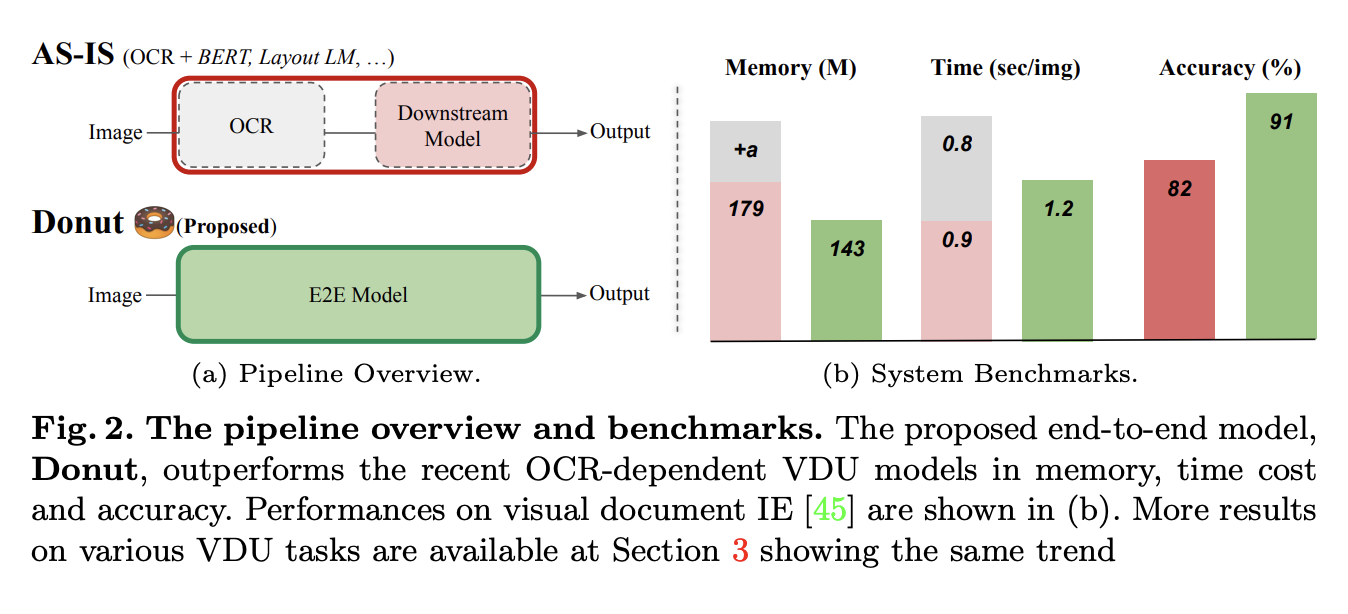

## 二、Donut 模型底层架构拆解

Donut 的核心架构是：



```
 [图像] → Swin Transformer → 图像特征
                    ↓
          Transformer Decoder (BART)
                    ↓
      [结构化 JSON 文本输出]
```



### 🧱 组件组成：

| 模块 | 描述 |
|------|------|
| 🖼️ Swin Transformer Encoder | 负责图像编码，将图片切块嵌入后提取局部和全局上下文特征 |
| 🔁 Transformer Decoder（BART） | 以序列方式生成结构化 JSON（如发票字段） |
| 🧾 Tokenizer | 使用 BART 或 XLM-R 支持多语言字符生成 |

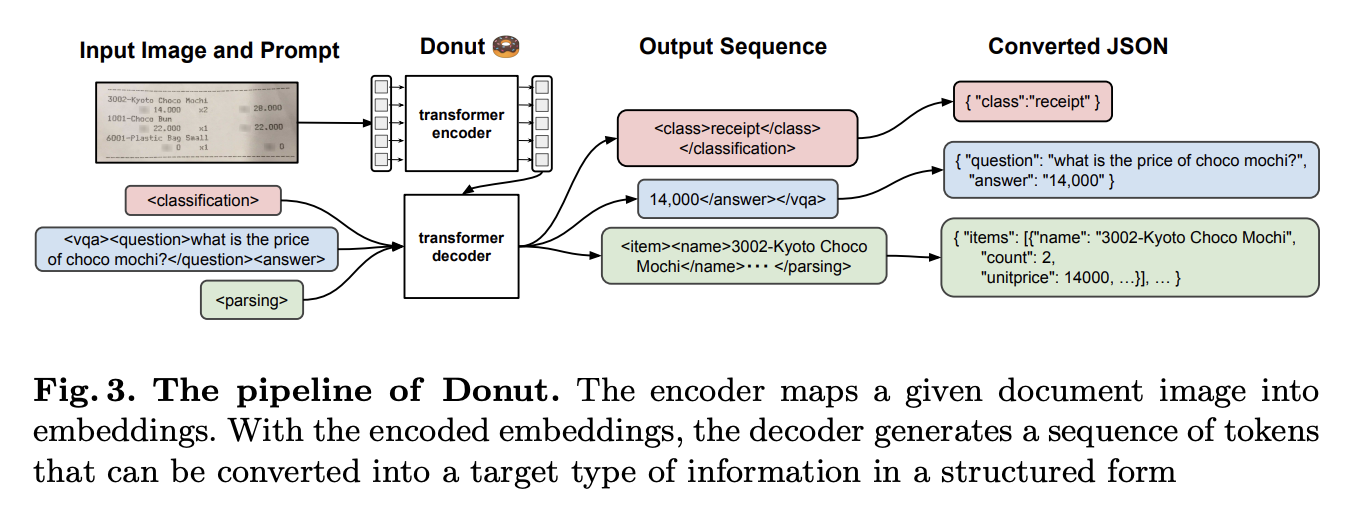

### 📥 示例输入图像（发票）

- 格式：PNG / JPEG / PDF
- 内容：中英文发票，含编号、金额、货币、税等字段


### 📤 示例输出 JSON（ground truth）

```json
{
  "InvoiceNo": "INV-001",
  "InvoiceDate": "2024-06-12",
  "Currency": "USD",
  "TotalAmount": "1299.00",
  "Tax": "99.00",
  "Items": [
    {"Name": "Laptop", "Price": "1200"}
  ],
  "Bank Info": "Bank of America, XXXX1234"
}
```

## 三、Donut 模型默认参数解释

### 📐 Donut 模型参数说明表

| 参数名                         | 默认值              | 含义说明 |
|------------------------------|-------------------|---------|
| `image_size`                 | `224`             | 图像输入大小，建议用于发票任务时设为更大的值如 `512`，以保留细节 |
| `patch_size`                 | `4`               | 图像切块大小，越小表示更细的视觉粒度 |
| `embed_dim`                  | `96`              | 每个图像 patch 的嵌入维度 |
| `depths`                     | `[2, 2, 6, 2]`     | Swin Transformer 每个 stage 的层数 |
| `num_heads`                  | `[3, 6, 12, 24]`   | 每个 stage 中多头注意力的头数 |
| `window_size`                | `7`               | Swin Transformer 中的局部窗口注意力大小 |
| `mlp_ratio`                  | `4.0`             | MLP 层中隐藏维度与输入维度的比例 |
| `drop_path_rate`             | `0.1`             | DropPath 的概率，增强模型泛化能力 |
| `hidden_dropout_prob`        | `0.0`             | MLP 层的 dropout 概率 |
| `attention_probs_dropout_prob` | `0.0`           | 注意力层的 dropout 概率 |
| `use_absolute_embeddings`    | `False`           | 是否使用绝对位置编码（默认使用相对位置编码，更适合文档类结构） |

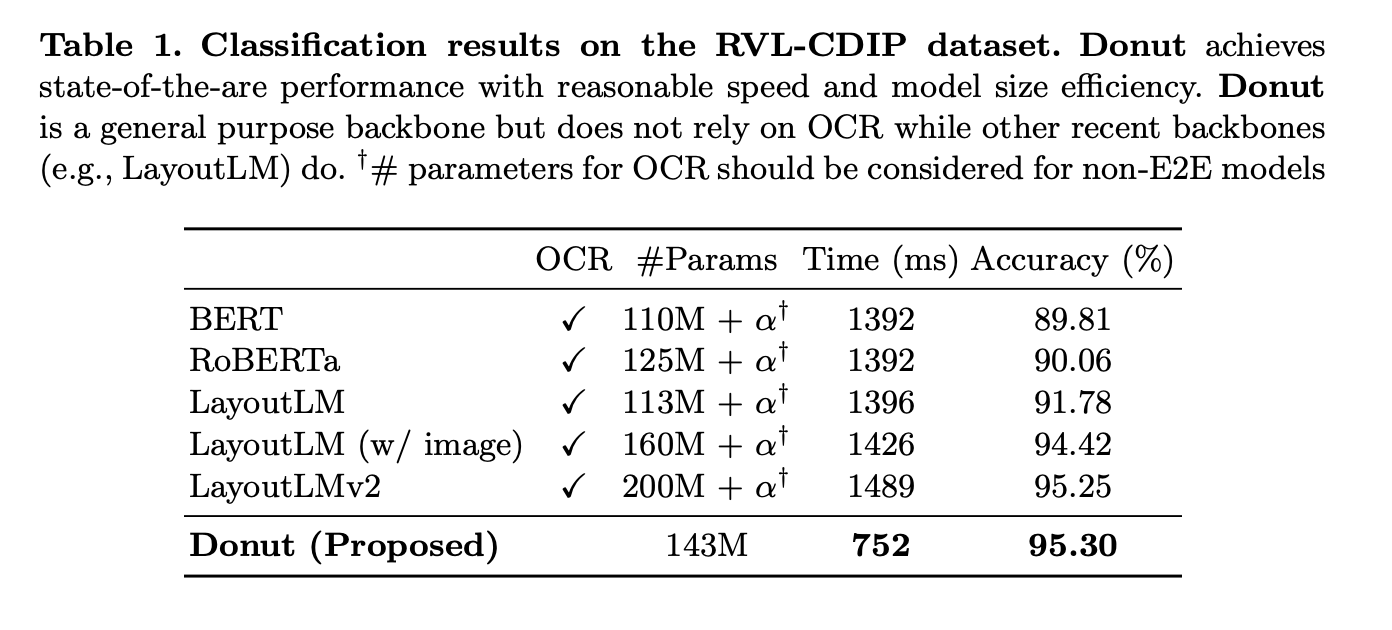

### 四、自定义 Donut-like 模型进行专属训练

参考 Donut 架构，自定义模型结构训练自己的发票数据集（中英文混排、多种币种格式）。


#### 1. 构建你的数据集

每个样本包含：


| 类型              | 示例                           | 说明                                                         |
|-------------------|--------------------------------|--------------------------------------------------------------|
| 图像              | `INV_001.jpg`                  | 发票或文档图片，通常为扫描件或照片                           |
| `ground_truth` JSON | `{ "InvoiceNo": "A12345", "InvoiceDate": "2025-07-01", ... }` | 结构化字段标签，模型要学习输出的目标                          |
| prompt            | `<s_invoice>`                  | 输入序列起始提示，用于控制模型生成不同类型的结构化输出       |


```
{
  "prompt": "<s_invoice>",
  "ground_truth": {
    "InvoiceNo": "INV-001",
    "TotalAmount": "1299.00",
    ...
  }
}
```




### 2. 自定义模型结构（示意）

In [ ]:
class DonutLikeModel(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder  # 图像编码器（如 Swin 或 ViT）
        self.decoder = decoder  # 文本解码器（如 BART）

    def forward(self, image, decoder_input_ids, labels=None):
        encoder_outputs = self.encoder(image)
        outputs = self.decoder(
            input_ids=decoder_input_ids,
            encoder_hidden_states=encoder_outputs,
            labels=labels
        )
        return outputs


## 3. 使用 HuggingFace 模块快速搭建


In [ ]:
# 图像编码器（可以用预训练的 ViT 或 Swin）

from transformers import ViTModel
encoder = ViTModel.from_pretrained("google/vit-base-patch16-224")

# 文本解码器（建议使用多语言支持的 BART）

from transformers import BartForConditionalGeneration
decoder = BartForConditionalGeneration.from_pretrained("facebook/bart-base")

# Tokenizer（建议支持中文）

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")  # 多语言支持

### 4.  模型训练参数建议表

| 训练参数     | 建议设置                   | 说明                                                                 |
|--------------|----------------------------|----------------------------------------------------------------------|
| 图像大小     | `image_size=512`           | 推荐使用较大的图像尺寸以保留发票的细节信息                         |
| 学习率       | `5e-5` 起，逐步调优        | 初始学习率建议从 `5e-5` 开始，微调时可使用学习率调度器               |
| 批次大小     | `4` ~ `16`（根据显存）     | 显存大的机器可适当增大 batch size，提高训练稳定性和收敛速度         |
| 损失函数     | `CrossEntropyLoss`         | 使用基于 token 的交叉熵损失（适用于生成类任务）                      |
| 优化器       | `AdamW`                    | 适用于 Transformer 架构的常用优化器，带有权重衰减                    |
| 训练轮数     | `3` ~ `10 epochs`          | 简单数据或模型基础好可少训练轮数，复杂任务需更长训练时间             |

In [1]:
#推荐模型配置示例

donut_config = {
    "image_size": 512,
    "patch_size": 4,
    "embed_dim": 192,
    "depths": [2, 2, 18, 2],
    "num_heads": [3, 6, 12, 24],
    "window_size": 7,
    "mlp_ratio": 4.0,
    "qkv_bias": True,
    "drop_path_rate": 0.2,
    "hidden_dropout_prob": 0.1,
    "attention_probs_dropout_prob": 0.1,
    "initializer_range": 0.02,
    "layer_norm_eps": 1e-5,
}

## 5. 实战建议：如何提升对复杂发票的支持

| 问题类型             | 解决建议                                                               |
|----------------------|------------------------------------------------------------------------|
| 多语言字符无法识别   | 使用自定义 tokenizer（如 SentencePiece）<br>扩展词表以覆盖中英混排 |
| 结构复杂如表格嵌套   | 使用更大图像尺寸（如 768）<br>加深 Swin Block 层数以增强特征建模     |
| 缺失字段（如税金）   | 添加额外推理 loss 或后处理规则<br>引入辅助字段（如 NetAmount）         |
| OCR 干扰/图像模糊    | 图像增强（模糊、旋转、仿射变换、加噪）<br>数据清洗以减少干扰样本       |

## 总结

Donut 架构非常适合文档抽取任务，你可以将其作为基础模板，替换模块、调整结构，微调成适配你发票数据的专属 AI 模型。

自定义训练 Donut 模型的关键点在于：

	1.	准备好高质量、统一格式的图像 + JSON 数据
	2.	明确字段目标结构（如 InvoiceNo、Tax、Currency 等）
	3.	选对 tokenizer + 视觉编码器
	4.	使用 seq2seq 模型输出结构文本

## 📚 资源推荐
	•	HuggingFace 文档：https://huggingface.co/docs/transformers/main/en/model_doc/donut
	•	官方 Donut repo：https://github.com/clovaai/donut
	•	Swin Transformer 论文：https://arxiv.org/abs/2103.14030
	•	示例训练项目：naver-clova-ix/donut